# Reanalysis of Yokota et al. 2020
Akira Endo

## Introduction
A paper recently published in *Clinical Infectious Diseases*, [Yokota et al. 2020](https://doi.org/10.1093/cid/ciaa1388), compared the results of polymerase chain reaction (PCR) tests for SARS-CoV-2 between nasopharyngeal swab (NPS) and saliva samples. The authors used a Bayesian-latent class model to simultaneously estimate the sensitivity and specificity of NPS/saliva PCR tests along with the unknown prevalence in the study cohorts (contact tracing and airport screening cohorts), and reported the sensitivity of 86% and 92% for NPS and saliva samples, respectively. The specificity of both tests were estimated to be over 99.9%. Compared with NPS, saliva samples are low-invasive and requires less involvement of healthcare professionals (which could also help protecting them from infection). Yokota et al. showed that saliva samples exhibited almost equivalent performance to NPS samples, which has a profound impact on the ongoing public health planning against COVID-19 which essentially requires efficient testing protocols. However we noticed, while we agree with the reported concordance between NPS and saliva tests, that the estimation model used to estimate the sensitivity (and specificity) of tests has a critical flaw and that the reported sensitivity of 86% and 92% are merely representative of positive agreement rates (PARs) between NPS and saliva samples. Although in the model these parameters (sensitivity) are appropriately defined as "the proportion testing positive in the truely infected individuals" using a latent variable $p$ (prevalence), the following two conditions in the model resulted in the estimated sensitivity almost identical statistical quantity as the PAR:
* The results of NPS and saliva tests are assumed to be statistically independent although the authors concluded in the manuscript that they are highly correlated (with a Kendall's W of 0.87);
* The prevalence $p$ was jointly estimated with other parameters, which resulted in the estimated sensitivity value almost solely determined by the PAR in the data.

Here, we reproduce the authors' analysis and assess whether the presented data has sufficient information that can distinguish the reported sensitivity from the PAR.

## Methods
First, we reproduce the analysis in the original study. For each of the two datasets $D_i$($i=1$: contact tracing and $i=2$: airport quarantine), we denote the number of individuals in the 2-by-2 table as

|  NPS　　　　　　　　| Saliva (+) | (-) |
|---------------------|--------|-----|
| (+)                 | A      | B   |
| (-)                 | C      | D   |

Under the assumption that the nasopharyngeal swab (NSP) and saliva tests are independent, the likelihood function assuming multinomial sampling is obtained as
$$
L_i\propto q_{A_i}^{A_i}q_{B_i}^{B_i}q_{C_i}^{C_i}q_{D_i}^{D_i},
$$
where
$$
q_{A_i}=p_iSe_NSe_S+(1-p_i)(1-Sp_N)(1-Sp_S),\\
q_{B_i}=p_iSe_N(1-Se_S)+(1-p_i)(1-Sp_N)Sp_S,\\
q_{C_i}=p_i(1-Se_N)Se_S+(1-p_i)Sp_N(1-Sp_S),\\
q_{D_i}=p_i(1-Se_N)(1-Se_S)+(1-p_i)Sp_NSp_S,
$$
and we get the posterior distribution of parameters $\theta=(Se_N,Se_S,Sp_N,Sp_S,p_1,p_2)$
$$
p(\theta| D_1, D_2)\propto p(\theta)L_1L_2
$$
where $p(\theta)$ represents the product of prior distributions. Markov-chain Monte Carlo (MCMC) was used to sample posterior distributions.

## Replication results

In [68]:
# Prepare functions & data
using Distributions, Mamba, RCall, Random
function qs(senses,specs,prev)
    [[senses[1],1-senses[1]]*[senses[2],1-senses[2]]', [1-specs[1],specs[1]]*[1-specs[2],specs[2]]'].*[prev,1-prev]|>sum
end
# 2×2 data tables
ctdata=[38 3
        6 114]
aqdata=[4 1
        0 1758]
struct Params{T,S} sens::T; spec::T; prev::S end
# Likelihood function
function Lᵢ(params,datatable)
    qm=qs(params.sens, params.spec, params.prev)
    sum(log.(qm).*datatable)
end

# MCMC
params=Dict{Symbol,Any}(
    :sens=>[0.8,0.8],
    :spec=>[0.95,0.95],
    :prev=>[0.1,0.1]
)
inputs=Dict{Symbol,Any}(
    :data=>(ctdata,aqdata),
    :zerotrick=>0.0
)
priors=Dict{Symbol,Any}(
    :sens=>Stochastic(1,()->Uniform(0,1)),
    :spec=>Stochastic(1,()->Beta(201,1)),
    :prev=>Stochastic(1,()->Uniform(0,1))
)
inits=[merge(params,inputs)]
model=Model(
    llvalue=Logical((sens,spec,prev,data)->Lᵢ.(Params.(Ref(sens),Ref(spec),prev),data)|>sum),
    zerotrick=Stochastic((llvalue)-> Poisson(-llvalue),false);
    priors...
)
setsamplers!(model,[NUTS(collect(keys(params)))])
Random.seed!(2020)
chain = mcmc(model,inputs,inits,50000, burnin=10000, thin=4, chains=1, verbose=true)
#draw(plot(chain))
describe(chain)

MCMC Simulation of 50000 Iterations x 1 Chain...

Chain 1:   0% [0:02:35 of 0:02:35 remaining]
Chain 1:  10% [0:02:08 of 0:02:22 remaining]
Chain 1:  20% [0:01:59 of 0:02:29 remaining]
Chain 1:  30% [0:01:47 of 0:02:33 remaining]
Chain 1:  40% [0:01:29 of 0:02:28 remaining]
Chain 1:  50% [0:01:12 of 0:02:25 remaining]
Chain 1:  60% [0:00:59 of 0:02:28 remaining]
Chain 1:  70% [0:00:45 of 0:02:28 remaining]
Chain 1:  80% [0:00:30 of 0:02:29 remaining]
Chain 1:  90% [0:00:15 of 0:02:29 remaining]
Chain 1: 100% [0:00:00 of 0:02:31 remaining]

Iterations = 10004:50000
Thinning interval = 4
Chains = 1
Samples per chain = 10000

Empirical Posterior Estimates:
              Mean            SD          Naive SE          MCSE          ESS   
prev[1]    0.2977095948 0.03619137135 0.0003619137135 0.0003718407935  9473.1849
prev[2]    0.0030169024 0.00133424465 0.0000133424465 0.0000119918499 10000.0000
spec[1]    0.9991233685 0.00072344518 0.0000072344518 0.0000075453639  9192.8648
spec[2]    0.9

We obtained the sensitivity estimates of 86% for NSP (95% credible interval: 75-94%) and 92% (95% CrI: 81-98%), consistent with Yokota et al. Note that 90% CrIs were reported instead of 95% CrIs in the original paper.

On the other hand, the PAR, the proportion testing positive among those testing positive for the reference test, is given as follows. Let $T_N$ be the PAR of NPS referencing saliva and $T_S$ vice versa. The likelihood of $T_N$ and $T_S$ are given as
$$
L_N(T_N)\propto T_N^{A_1}{(1-T_N)}^{C_1}T_N^{A_2}{(1-T_N)}^{C_2} \\
L_N(T_S)\propto T_S^{A_1}{(1-T_S)}^{B_1}T_S^{A_2}{(1-T_S)}^{B_2}
$$
and can simply be sampled from beta distributions $Beta(\sum A_i+1,\sum C_i+1)$ and $Beta(\sum A_i+1,\sum B_i+1)$, respectively.

The estimated sensitivity values and PARs had almost identical distribution, which suggests that the sensitivity estimates were almost exclusively informed by the reference positive data; i.e. the sensitivity of NPS was estimated from saliva positive data, and vice versa. Reference negative data was barely informative because the negative samples among them (i.e. negative-negative samples) could also be true negatives (noninfecteds). Since the prevalence $p$ was treated as unknown and freely estimated, any data could have been consistent with the PAR estimated from the reference positive data, thereby not contributing estimation of sensitivity.

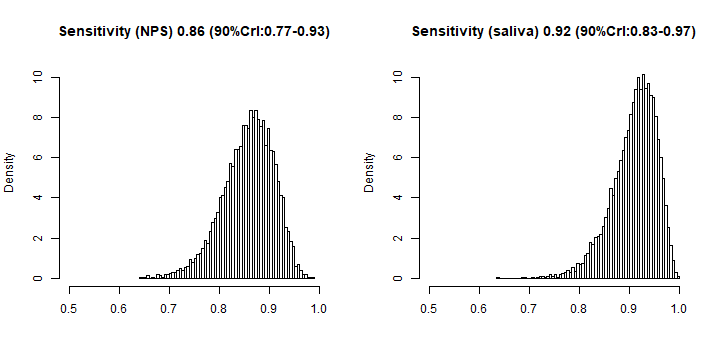

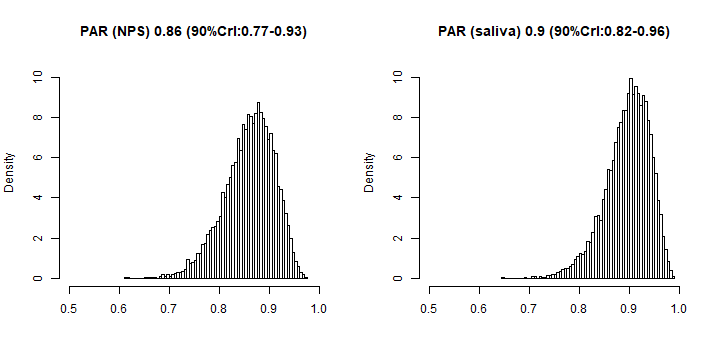

In [82]:
using RCall;@rimport graphics as rgr;@rimport repr as rpr;@rimport base as r
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 720, :height => 360)); rgr.par(mfrow=[1,2])
SeN=chain[:,"sens[1]",:].value|>vec; SeNCrI=round.(quantile.(Ref(SeN),[0.05,0.95]),digits=2)
SeS=chain[:,"sens[2]",:].value|>vec; SeSCrI=round.(quantile.(Ref(SeS),[0.05,0.95]),digits=2)
rgr.hist(SeN,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "Sensitivity (NPS) "*string(round(median(SeN),digits=2))*" (90%CrI:"*prod(string.(SeNCrI[1],"-",SeNCrI[2]))*")")
rgr.hist(SeS,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "Sensitivity (saliva) "*string(round(median(SeS),digits=2))*" (90%CrI:"*prod(string.(SeSCrI[1],"-",SeSCrI[2]))*")");

TN=rand(Beta(42+1,6+1),10000); TNCrI=round.(quantile.(Ref(TN),[0.05,0.95]),digits=2)
TS=rand(Beta(42+1,4+1),10000); TSCrI=round.(quantile.(Ref(TS),[0.05,0.95]),digits=2)
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 720, :height => 360)); rgr.par(mfrow=[1,2])
rgr.hist(TN,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "PAR (NPS) "*string(round(median(TN),digits=2))*" (90%CrI:"*prod(string.(TNCrI[1],"-",TNCrI[2]))*")")
rgr.hist(TS,xlab="",100,freq=false,xlim=[0.5,1],ylim=[0,10.5], main = "PAR (saliva) "*string(round(median(TS),digits=2))*" (90%CrI:"*prod(string.(TSCrI[1],"-",TSCrI[2]))*")");

**Figure 1.** Posterior distributions of Sensitivity and positive agreement rates (PARs)

In [ ]:

Lₓ = function(sens,prev,data)
    data.*log.(qs(sens, 1, prev))|>sum
end
fₓ(params,datatables,testtype)=begin
    datas=getindex.(datatables,testtype,:)
    sum(Lᵢ.(Ref(params),datatables))./sum(Lₓ.(params.sens[testtype],params.prev,datas))
end
margsens = function(params, datatable)
    Lᵢ(params,datatable)/

Note that by substituting $T_N$ and $T_S$ in the above likelihood functions with $q_A/(q_A+q_C)$ and $q_A/(q_A+q_B)$, respectively, we can obtain the likelihood which estimates $(Se_N,Se_S)$ as the positive agreement ratio instead of sensitivity. This likelihood component constitutes a part of the posterior distribution $p(\theta| D_1, D_2)$ Therefore, we can assess the extent to which the posterior distribution of sensitivity $(Se_N,Se_S)$ was informed by the data, aside from positive agreement ratio, by dividing the likelihoods:
$$
f_N(\theta)= \frac{L_1L_2}{L_N\left(\frac{q_A}{q_A+q_C}\right)}=\\
f_S(\theta)= \frac{L_1L_2}{L_N\left(\frac{q_A}{q_A+q_B}\right)}.
$$
That is, $f_N(\theta)$ is the partial likelihood that represents the information in the data excluding that on $T_N$, and $f_S(\theta)$ exluding that on $T_S$. We can therefore assess the distinction between the estimated sensitivity and positive agreement ratio by how informative the marginal distributions $\int f_N(\theta|Se_N=x)d\theta$ and $\int f_S(\theta|Se_S=x)d\theta$ are.

In [108]:
inputs[:data][1][3:end].=0;inputs[:data][2][3:end].=0;
inits=[merge(params,inputs)]
chain = mcmc(model,inputs,inits,50000, burnin=10000, thin=4, chains=1, verbose=true)

MCMC Simulation of 50000 Iterations x 1 Chain...

Chain 1:   0% [0:01:25 of 0:01:25 remaining]
Chain 1:  10% [0:01:43 of 0:01:54 remaining]
Chain 1:  20% [0:01:28 of 0:01:50 remaining]
Chain 1:  30% [0:01:16 of 0:01:49 remaining]
Chain 1:  40% [0:01:06 of 0:01:49 remaining]
Chain 1:  50% [0:00:56 of 0:01:51 remaining]
Chain 1:  60% [0:00:45 of 0:01:53 remaining]
Chain 1:  70% [0:00:34 of 0:01:54 remaining]
Chain 1:  80% [0:00:23 of 0:01:53 remaining]
Chain 1:  90% [0:00:11 of 0:01:52 remaining]
Chain 1: 100% [0:00:00 of 0:01:52 remaining]



Object of type "ModelChains"

Iterations = 10004:50000
Thinning interval = 4
Chains = 1
Samples per chain = 10000

[0.9674964813241186 0.8331572669439533 … 0.9960229623086285 -20.547346477137044; 0.9782341343895118 0.8784675330984985 … 0.9709864303511337 -21.333846397513366; … ; 0.9973729878865215 0.9618778223907751 … 0.9953394393840378 -18.585051837579233; 0.971635303528956 0.954454184538991 … 0.9928751230533565 -19.962596223208305]

infected_breakdown = r.table(NPS=(rmv .> thresholds)[1, :], saliva=(rmv .> thresholds)[2, :] |> collect) = RObject{IntSxp}
       saliva
NPS     FALSE TRUE
  FALSE    12    3
  TRUE      7   39



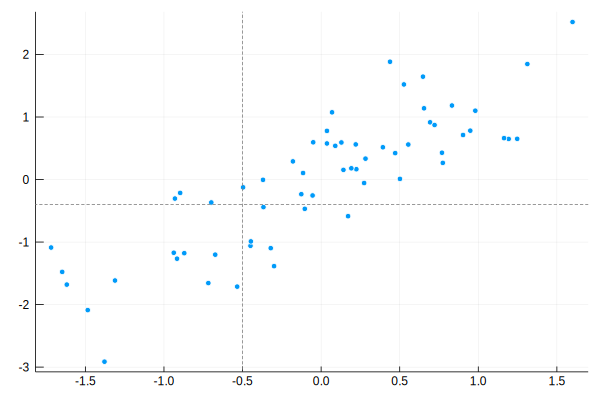

In [169]:
@rimport synchrony as sync; @rimport base as r
function generatesamples(cor,truetests,thresholds)
    truepos=truetests[1];trueneg=truetests[2]
    rmv=rand(MvNormal([1 cor;cor 1]),truepos)
    @show infected_breakdown=r.table(NPS=(rmv.>thresholds)[1,:],saliva=(rmv.>thresholds)[2,:]|>collect)
    dtable=rcopy(infected_breakdown)[[2,1],[2,1]] + [0 0;0 trueneg] # flip and add true negs
    return dtable, rmv
end
Random.seed!(2020)
thresholds=[-0.5,-0.4]
reprdata, reprctvalues=generatesamples(0.8,(61,100),thresholds)
scatter(reprctvalues[1,:],reprctvalues[2,:],markerstrokewidth=0,legend=false)
Plots.plot!([thresholds[1]], linetype=:vline,color=:gray,line=:dash);Plots.plot!([thresholds[2]], linetype=:hline,color=:gray,line=:dash)

In [126]:
function kendallw(ctvalues,thresholds)
    positives=ctvalues[:,any(ctvalues.>thresholds,dims=1)|>vec]
    sync.kendall_w(positives')
end
kendallw(reprctvalues,[-0.5,-0.4])

RObject{VecSxp}
Kendall's W (uncorrected for ties): 0.8775
Kendall's W (corrected for ties): 0.8775
Spearman's ranked correlation: 0.755